# **Tutorial for hierarchical Bayesian inference for Reinforcement Learning - Sequential Sampling Models.**

This is a (preview) tutorial for using the HSSM Python package to simultaneously estimate reinforcement learning parameters and decision parameters within a fully hierarchical bayesian estimation framework, including steps for constructing HSSM-compatible likelihoods/distributions and sampling from the posterior. Further, the plots to assess the recovery of model parameters are also shown. 

The module uses the reinforcement learning sequential sampling model (RLSSM), a reinforcement learning model that replaces the standard “softmax” choice function with a drift diffusion process with collapsing bounds (referred to as the 'angle' model hereon). The softmax and sequential sampling process is equivalent for capturing choice proportions, but the angle model also takes RT distributions into account; options are provided to also only fit RL parameters without RT. The RLSSM estimates trial-by-trial drift rate as a scaled difference in expected rewards (expected reward for upper bound alternative minus expected reward for lower bound alternative). Expected rewards are updated with a delta learning rule using either a single learning rate or with separate learning rates for positive and negative prediction errors. The model also includes the standard angle parameters. The broader RLSSM framework is described in detail in [Pedersen, Frank & Biele (2017)](https://ski.clps.brown.edu/papers/PedersenEtAl_RLDDM.pdf) and [Fengler, Bera, Pedersen & Frank (2022)](https://direct.mit.edu/jocn/article/34/10/1780/112585/Beyond-Drift-Diffusion-Models-Fitting-a-Broad).

In [1]:
# Import necessary libraries
import numpy as np
import arviz as az
import pickle
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from functools import partial
from scipy.stats import spearmanr

# Import HSSM and simulator package
import hssm
from hssm.utils import decorate_atomic_simulator
from hssm.likelihoods.rldm import make_rldm_logp_op
from hssm.distribution_utils.dist import make_hssm_rv
from ssms.basic_simulators.simulator import simulator

In [2]:
# Set the style for the plots
plt.style.use('seaborn-v0_8-dark-palette')

## Load and prepare the demo dataset
This data file contains (synthetic) data from a simulated 2-armed bandit task. We examine the dataset -- it contains the typical columns that are expected from a canonical instrumental learning task. `participant_id` identifies the subject id, `trial` identifies the sequence of trials within the subject data, `response` and `rt` are the data columns recorded for each trial, `feedback` column shows the reward obtained on a given trial and `correct` records whether the response was correct. 

In [3]:
# load pickle file

with open("../../tests/fixtures/rlwm_data.pickle", "rb") as f:
    datafile = pickle.load(f) 

/var/folders/x0/fmky6rx50nlb2gv47r2586k80000gn/T/ipykernel_27284/1621081835.py:4: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  datafile = pickle.load(f)


In [4]:
dataset = datafile["sim_data"]
dataset

,participant_id,block_id,stimulus_id,response,feedback,rt,acc,stim_ctr,set_size,unidim_mask,new_block_start,correct_response
0,0.0,0.0,1.0,1.0,1.0,0.905485,1.0,1.0,5.0,0.0,1.0,1.0
1,0.0,0.0,4.0,0.0,0.0,0.687666,0.0,1.0,5.0,0.0,0.0,2.0
2,0.0,0.0,2.0,1.0,0.0,0.708184,0.0,1.0,5.0,0.0,0.0,0.0
3,0.0,0.0,1.0,1.0,1.0,0.514008,1.0,2.0,5.0,0.0,0.0,1.0
4,0.0,0.0,4.0,2.0,1.0,0.836765,1.0,2.0,5.0,0.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...
31315,86.0,9.0,0.0,2.0,1.0,0.830150,1.0,9.0,3.0,0.0,0.0,2.0
31316,86.0,9.0,0.0,2.0,1.0,0.827908,1.0,10.0,3.0,0.0,0.0,2.0
31317,86.0,9.0,2.0,2.0,1.0,0.611198,1.0,9.0,3.0,0.0,0.0,2.0
31318,86.0,9.0,1.0,2.0,1.0,1.029457,1.0,10.0,3.0,0.0,0.0,2.0


In [5]:
dataset = dataset[dataset['participant_id'] < 20]
n_participants = 20
n_trials = 360

dataset

,participant_id,block_id,stimulus_id,response,feedback,rt,acc,stim_ctr,set_size,unidim_mask,new_block_start,correct_response
0,0.0,0.0,1.0,1.0,1.0,0.905485,1.0,1.0,5.0,0.0,1.0,1.0
1,0.0,0.0,4.0,0.0,0.0,0.687666,0.0,1.0,5.0,0.0,0.0,2.0
2,0.0,0.0,2.0,1.0,0.0,0.708184,0.0,1.0,5.0,0.0,0.0,0.0
3,0.0,0.0,1.0,1.0,1.0,0.514008,1.0,2.0,5.0,0.0,0.0,1.0
4,0.0,0.0,4.0,2.0,1.0,0.836765,1.0,2.0,5.0,0.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...
7195,19.0,9.0,0.0,2.0,1.0,0.524149,1.0,9.0,3.0,0.0,0.0,2.0
7196,19.0,9.0,2.0,0.0,1.0,0.391745,1.0,9.0,3.0,0.0,0.0,0.0
7197,19.0,9.0,0.0,2.0,1.0,0.559724,1.0,10.0,3.0,0.0,0.0,2.0
7198,19.0,9.0,2.0,0.0,1.0,0.495000,1.0,10.0,3.0,0.0,0.0,0.0


In [6]:
# # Load synthetic RLSSM dataset containing both behavioral data and ground truth parameters
# savefile = np.load("../../tests/fixtures/rldm_data.npy", allow_pickle=True).item()
# dataset = savefile['data']

# # Rename trial column to match HSSM conventions
# dataset.rename(columns={'trial': 'trial_id'}, inplace=True)

# # Examine the dataset structure
# dataset.head()

# # Validate data structure and extract dataset configuration 
# dataset, n_participants, n_trials = hssm.check_data_for_rl(dataset)

# print(f"Number of participants: {n_participants}")
# print(f"Number of trials: {n_trials}")

# Construct HSSM-compatible PyMC distribution from a simulator and JAX likelihood callable

We now construct a custom model that is compatible with HSSM and PyMC. Note that HSSM internally constructs a PyMC object (which is used for sampling) based on the user-specified HSSM model. In other words, we are peeling the abstration layers conveniently afforded by HSSM to directly use the core machinery of HSSM. This advanced [HSSM tutorial](https://lnccbrown.github.io/HSSM/tutorials/jax_callable_contribution_onnx_example/) explains how to use HSSM when starting from the very basics of a model -- a simulator and a JAX likelihood callable. 

The simulator function is used for generating samples from the model (for posterior predictives, etc.) and the likelihood callable is employed for sampling/inference. This preview tutorial exposes the key flexibility of the HSSM for use in fitting RLSSM models. Therefore, the subsequent tutorial will focus only on the sampling/inference aspect. We create a dummy simulator function to bypass the need for defining the actual simulator.

### Step 1: Define a pytensor RandomVariable

In [7]:
# Define parameters for the RLSSM model (RL + decision model parameters)
list_params = ['a', 'z', 'theta', 'alpha', 'phi', 'rho', 'gamma', 'epsilon', 'C', 'eta']

# Create a dummy simulator for generating synthetic data (used for posterior predictives)
# This bypasses the need for a full RLSSM simulator implementation
def create_dummy_simulator():
    """Create a dummy simulator function for RLSSM model."""
    def sim_wrapper(simulator_fun, theta, model, n_samples, random_state, **kwargs):
        # Generate random RT and choice data as placeholders
        sim_rt = np.random.uniform(0.2, 0.6, n_samples)
        sim_ch = np.random.randint(0, 3, n_samples)
        
        return np.column_stack([sim_rt, sim_ch])

    # Wrap the simulator function with required metadata
    wrapped_simulator = partial(sim_wrapper, simulator_fun=simulator, model="custom", n_samples=1)

    # Decorate the simulator to make it compatible with HSSM
    return decorate_atomic_simulator(model_name="custom", choices=[0, 1], obs_dim=2)(wrapped_simulator)

# Create the simulator and RandomVariable
decorated_simulator = create_dummy_simulator()

# Create a PyTensor RandomVariable using `make_hssm_rv` for use in the PyMC model
CustomRV = make_hssm_rv(
    simulator_fun=decorated_simulator, list_params=list_params
)

### Step 2: Define a likelihood function

In [8]:
# Create a Pytensor Op for the likelihood function.
# The `make_rldm_logp_op` function is a utility that wraps the base JAX likelihood function into a HSSM/PyMC-compatible callable.

logp_jax_op = make_rldm_logp_op(
    n_participants=n_participants,
    n_trials=n_trials,
    n_params=10
)

In [9]:
# Test the likelihood function

def extract_data_columns(dataset):
    """Extract required data columns from dataset."""
    return {
        'rt': dataset["rt"].values,
        'response': dataset["response"].values,
        'participant_id': dataset["participant_id"].values,
        'set_size': dataset["set_size"].values,
        'stimulus_id': dataset["stimulus_id"].values,
        'feedback': dataset["feedback"].values,
        'new_block_start': dataset["new_block_start"].values,
        'unidim_mask': dataset["unidim_mask"].values,
    }

def create_test_parameters(n_trials):
    """Create dummy parameters for testing the likelihood function."""
    return {
        'a': np.ones(n_trials) * 1.5,
        'z': np.ones(n_trials) * 0.4,
        'theta': np.ones(n_trials) * 0.1,
        'alpha': np.ones(n_trials) * 0.003,
        'phi': np.ones(n_trials) * 0.3,
        'rho': np.ones(n_trials) * 0.7,
        'gamma': np.ones(n_trials) * 0.3,
        'epsilon': np.ones(n_trials) * 0.2,
        'C': np.ones(n_trials) * 3.5,
        'eta': np.ones(n_trials) * 0.8,
}

# Extract data and create test parameters
data_columns = extract_data_columns(dataset)
num_subj = len(np.unique(data_columns['participant_id']))
n_trials_total = num_subj * 360

test_params = create_test_parameters(n_trials_total)

# Evaluate the likelihood function
test_logp_out = logp_jax_op(
    np.column_stack((data_columns['rt'], data_columns['response'])),
    test_params['a'],
    test_params['z'],
    test_params['theta'],
    test_params['alpha'],
    test_params['phi'],
    test_params['rho'],
    test_params['gamma'],
    test_params['epsilon'],
    test_params['C'],
    test_params['eta'],
    data_columns['participant_id'],
    data_columns['set_size'],
    data_columns['stimulus_id'],
    data_columns['feedback'],
    data_columns['new_block_start'],
    data_columns['unidim_mask'],
)

LL = test_logp_out.eval()
print(f"Log likelihood: {np.sum(LL):.4f}")

Log likelihood: -95428.7823


### Step 3: Define a model config and HSSM model

In [10]:
# Step 3: Define the model config

# Configure the HSSM model 
model_config = hssm.ModelConfig(
    response=["rt", "response"],        # Dependent variables (RT and choice)
    list_params=                        # List of model parameters
        ['a', 'z', 'theta', 'alpha', 'phi', 'rho', 'gamma', 'epsilon', 'C', 'eta'],   
    choices=[0, 1, 2],                     # Possible choice options
    default_priors={},                  # Use custom priors (defined below)
    bounds=dict(                        # Parameter bounds for optimization
        a=(0.1, 6),
        z=(0.0, 0.9),                   
        theta=(0.0, 1.2),                
        alpha=(-7.0, -4.6),
        phi=(0.0, 1.0),
        rho=(0.0, 1.0),
        gamma=(0.0, 1.0),
        epsilon=(0.0, 0.5),
        C=(1.0, 5.0),
        eta=(0.1, 2.0)
        ),
    rv=CustomRV,                        # Custom RandomVariable that we created earlier
    extra_fields=[                      # Additional data columns to be passed to the likelihood function as extra_fields
        "participant_id", 
        "set_size",
        "stimulus_id",
        "feedback",
        "new_block_start",
        "unidim_mask",
        ],  
    backend="jax"                       # Use JAX for computation
)

In [38]:
# Create a hierarchical HSSM model with custom likelihood function
hssm_model = hssm.HSSM(
    data=dataset,                        # Input dataset
    model_config=model_config,           # Model configuration
    p_outlier=0,                         # No outlier modeling
    lapse=None,                          # No lapse rate modeling
    loglik=logp_jax_op,                  # Custom RLDM likelihood function
    loglik_kind="approx_differentiable", # Use approximate gradients
    noncentered=False,                    # Use non-centered parameterization
    process_initvals=False,              # Skip initial value processing in HSSM
    include=[
        # Define hierarchical priors: group-level intercepts + subject-level random effects
        hssm.Param("a", 
                formula="a ~ 1 + (1|participant_id)", 
                prior={"Intercept": hssm.Prior("TruncatedNormal", lower=0.1, upper=6, mu=0.5, initval=0.5)}),
        hssm.Param("z", 
                formula="z ~ 1 + (1|participant_id)", 
                prior={"Intercept": hssm.Prior("TruncatedNormal", lower=0.0, upper=0.9, mu=0.2, initval=0.2)}),
        hssm.Param("theta", 
                formula="theta ~ 1 + (1|participant_id)", 
                prior={"Intercept": hssm.Prior("TruncatedNormal", lower=0.00, upper=1.2, mu=0.3, initval=0.3)}),
        hssm.Param("alpha", 
                formula="alpha ~ 1 + (1|participant_id)",
                prior={"Intercept": hssm.Prior("TruncatedNormal", lower=-7.0, upper=-4.6, mu=-5.5, initval=-5.5)}),
        hssm.Param("phi", 
                formula="phi ~ 1 + (1|participant_id)",
                prior={"Intercept": hssm.Prior("TruncatedNormal", lower=0.0, upper=1.0, mu=0.2, initval=0.2)}),
        hssm.Param("rho", 
                formula="rho ~ 1 + (1|participant_id)", 
                prior={"Intercept": hssm.Prior("TruncatedNormal", lower=0.0, upper=1.0, mu=0.5, initval=0.5)}),
        hssm.Param("gamma", 
                formula="gamma ~ 1 + (1|participant_id)",
                prior={"Intercept": hssm.Prior("TruncatedNormal", lower=0.0, upper=1.0, mu=0.1, initval=0.1)}),
        hssm.Param("epsilon", 
                formula="epsilon ~ 1 + (1|participant_id)",
                prior={"Intercept": hssm.Prior("TruncatedNormal", lower=0.0, upper=0.1, mu=0.02, initval=0.02)}),
        hssm.Param("C", 
                formula="C ~ 1 + (1|participant_id)",
                prior={"Intercept": hssm.Prior("TruncatedNormal", lower=1.0, upper=5.0, mu=2.5, initval=2.5)}),
        hssm.Param("eta", 
                formula="eta ~ 1 + (1|participant_id)",
                prior={"Intercept": hssm.Prior("TruncatedNormal", lower=0.1, upper=2.0, mu=1.0, initval=1.0)}),
    ]
)

No common intercept. Bounds for parameter a is not applied due to a current limitation of Bambi. This will change in the future.
No common intercept. Bounds for parameter z is not applied due to a current limitation of Bambi. This will change in the future.
No common intercept. Bounds for parameter theta is not applied due to a current limitation of Bambi. This will change in the future.
No common intercept. Bounds for parameter alpha is not applied due to a current limitation of Bambi. This will change in the future.
No common intercept. Bounds for parameter phi is not applied due to a current limitation of Bambi. This will change in the future.
No common intercept. Bounds for parameter rho is not applied due to a current limitation of Bambi. This will change in the future.
No common intercept. Bounds for parameter gamma is not applied due to a current limitation of Bambi. This will change in the future.
No common intercept. Bounds for parameter epsilon is not applied due to a current

In [39]:
hssm_model.initvals

{'a_Intercept': array(0.5),
 'a_1|participant_id_mu': array(0.),
 'a_1|participant_id_sigma': array(0.27082359),
 'a_1|participant_id': array([-0.00609534,  0.00711659,  0.00100053,  0.00640197,  0.00584437,
        -0.00809237, -0.00865371,  0.00365292, -0.00515377,  0.00916522,
         0.00616267, -0.00328771, -0.00040869,  0.00885343, -0.00068692,
        -0.00089339,  0.00168498,  0.00336153,  0.00758564, -0.00723777]),
 'z_Intercept': array(0.2),
 'z_1|participant_id_mu': array(0.),
 'z_1|participant_id_sigma': array(0.27082359),
 'z_1|participant_id': array([ 9.58198030e-03,  6.10256940e-03,  7.99741223e-03, -7.81630115e-06,
        -7.73580000e-03, -2.81746918e-03, -4.84167924e-03,  1.67717098e-03,
        -5.05552022e-03, -6.47253531e-04,  5.98031608e-03,  9.68790241e-03,
         6.34669606e-03,  9.75689571e-03,  1.94374891e-03, -8.73824395e-03,
         8.78173951e-03,  1.14631257e-03, -4.99753049e-03,  9.78373573e-04]),
 'theta_Intercept': array(0.3),
 'theta_1|participant_

# Sample using NUTS MCMC

In [ ]:
# Run MCMC sampling using NUTS sampler with JAX backend
# Note: Using small number of samples for demonstration (increase for real analysis)
idata_mcmc = hssm_model.sample(
    sampler='numpyro',  # JAX-based NUTS sampler for efficiency
    chains=1,                # Number of parallel chains
    draws=500,                # Number of posterior samples
    tune=500,                 # Number of tuning/warmup samples
)

Using default initvals. 



sample: 100%|██████████| 1000/1000 [07:39<00:00,  2.18it/s, 23 steps of size 3.72e-02. acc. prob=0.78]
There were 500 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks
/Users/krishnbera/Documents/revert_rldm/HSSM/.venv/lib/python3.12/site-packages/pymc/pytensorf.py:958: FutureWarning: compile_pymc was renamed to compile. Old name will be removed in a future release of PyMC
  warnings.warn(
100%|██████████| 500/500 [00:04<00:00, 106.94it/s]


In [41]:
idata_mcmc

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

# Assess the model fits

We examine the quality of fits by comparing the recovered parameters with the ground-truth data generating parameters of the simulated dataset. 
We examine the quality of fits both at group-level as well as subject-level.

## Examining group-level posteriors

In [42]:
# Define parameter names for analysis

list_group_mean_params = [
    "a_Intercept",
    "z_Intercept",
    "theta_Intercept",
    "alpha_Intercept",
    "phi_Intercept",
    "rho_Intercept",
    "gamma_Intercept",
    "epsilon_Intercept",
    "C_Intercept",
    "eta_Intercept",
]

list_group_sd_params = [
    "a_1|participant_id_sigma",
    "z_1|participant_id_sigma",
    "theta_1|participant_id_sigma",
    "alpha_1|participant_id_sigma",
    "phi_1|participant_id_sigma",
    "rho_1|participant_id_sigma",
    "gamma_1|participant_id_sigma",
    "epsilon_1|participant_id_sigma",
    "C_1|participant_id_sigma",
    "eta_1|participant_id_sigma",
]

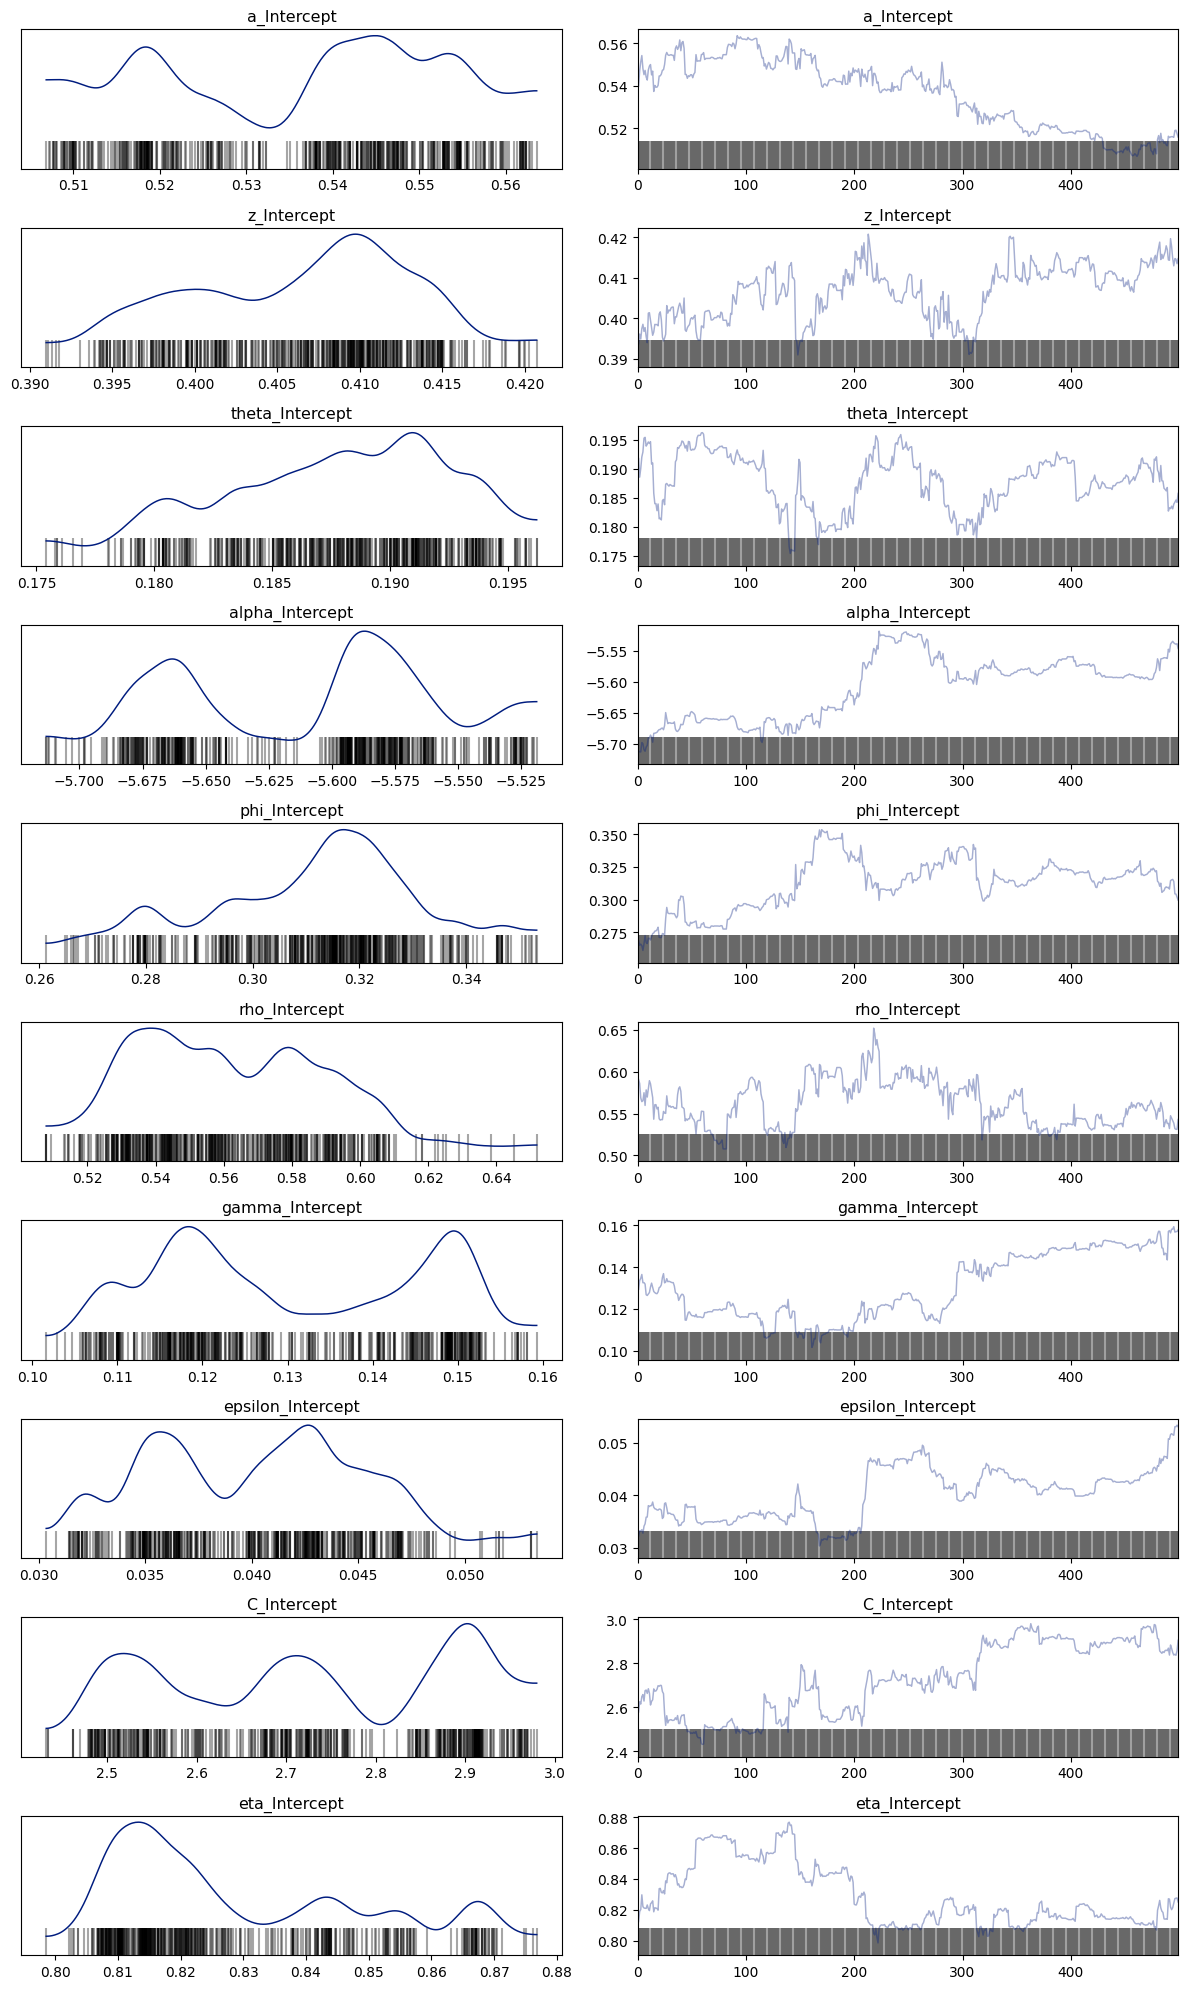

In [45]:
# plot the posterior pair plots of the group-level parameters
# this will show the joint distributions and correlations between the group-level parameters.
az.plot_trace(idata_mcmc, var_names=list_group_mean_params, ) # kind='kde', point_estimate='mean'
plt.tight_layout()

## Examining participant-level posteriors

In [46]:
# Extract ground truth subject-level parameters from the synthetic dataset
# Reshape from dictionary format to matrix (subjects x parameters)
sim_param_list = datafile['sim_param_list']

In [47]:
sim_param_list = sim_param_list[0:20, :]
print(sim_param_list.shape)

(20, 10)


In [48]:
idata_mcmc.posterior['alpha_Intercept'].values[0].shape

(500,)

In [49]:
# Function to extract subject-level parameters from inference data.
def extract_subject_parameters(idata, param_names):
    
    n_subjects = idata.posterior[f'{param_names[0]}_1|participant_id'].shape[-1]
    n_params = len(param_names)
    
    subject_params = np.zeros((n_subjects, n_params))
    
    for i, param in enumerate(param_names):
        intercept = np.mean(idata.posterior[f'{param}_Intercept'].values[0])
        random_effects = np.mean(idata.posterior[f'{param}_1|participant_id'].values[0], axis=0)
        subject_params[:, i] = intercept + random_effects
    
    return subject_params

# Extract recovered parameters
recov_param_list = extract_subject_parameters(idata_mcmc, model_config.list_params)

In [50]:
print(recov_param_list.shape)

(20, 10)


In [51]:
plot_param_ranges = [[0.1, 1.5], [0, 1], [0, 1.2], [-7, -4], [0, 1], [0, 1], [0, 1], [0, 0.5], [1, 5], [0.1, 2]]
plot_param_names = ["a", "z", "theta", "alpha", "phi", "rho", "gamma", "epsilon", "C", "eta"]

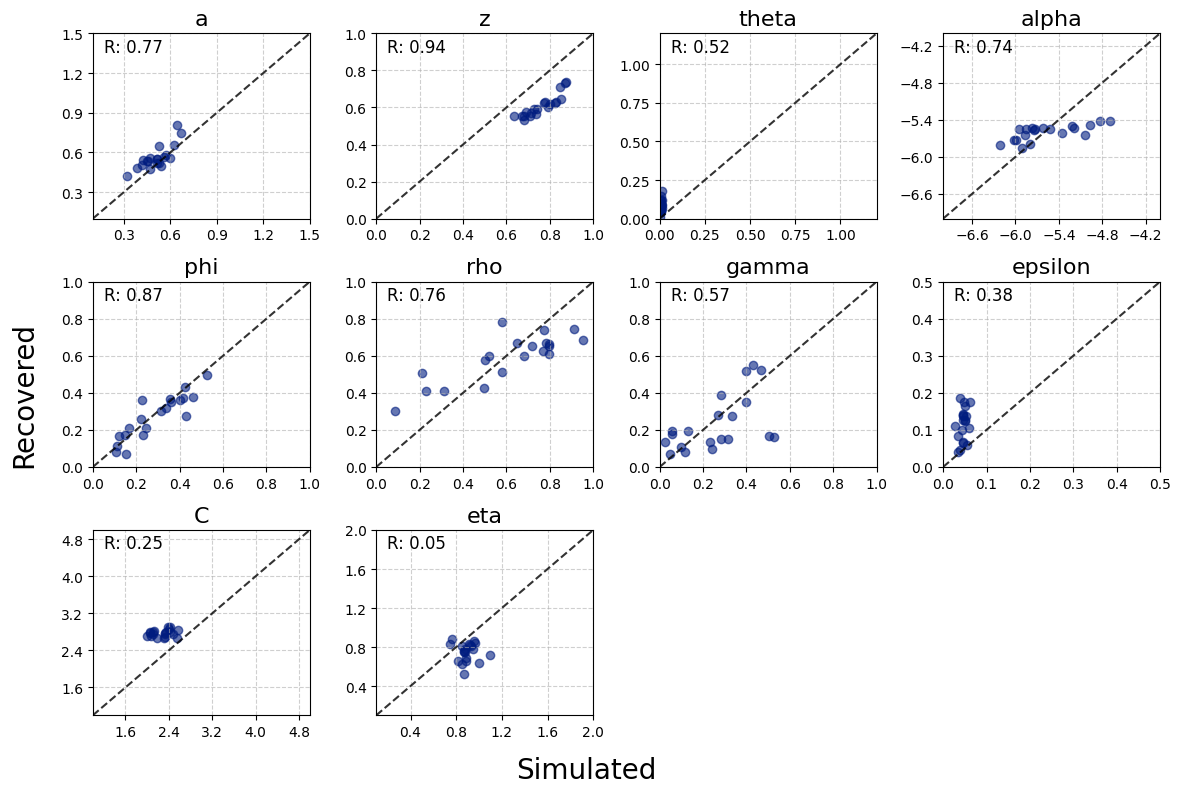

In [52]:
# Function to create parameter recovery plots comparing simulated vs recovered values
def plot_parameter_recovery(sim_params, recov_params, param_names, axes_limits, 
                          additional_data=None, additional_label=None, show_correlation=False):

    fig, axes = plt.subplots(3, 4, figsize=(12, 8))
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        if i >= len(param_names):
            ax.set_visible(False)
            continue

        x, y = sim_params[:, i], recov_params[:, i]
        
        # Scatter plot showing parameter recovery 
        ax.scatter(x, y, alpha=0.6, label='MCMC' if additional_data is None else 'MCMC')
            
        # Additional data if provided
        if additional_data is not None:
            z = additional_data[:, i]
            ax.scatter(x, z, alpha=0.6, marker='x', label=additional_label or 'Additional')
            ax.legend(loc='lower right')

        # Calculate and display correlation between true and recovered parameters
        if show_correlation:
            spearman_r, _ = spearmanr(x, y)
            ax.text(0.05, 0.88, f"R: {spearman_r:.2f}", transform=ax.transAxes, 
                        fontsize=12, verticalalignment='bottom')

        # Formatting subplot
        ax.set_title(param_names[i], fontsize=16)
        ax.set_xlim(axes_limits[i])
        ax.set_ylim(axes_limits[i])
        ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
        ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
        ax.grid(True, linestyle='--', alpha=0.6)
        ax.axline((0, 0), linestyle='--', slope=1, c='k', alpha=0.8)  # Perfect recovery line

    # Add axis labels
    fig.text(0.5, 0.02, 'Simulated', ha='center', fontsize=20)
    fig.text(0.02, 0.5, 'Recovered', va='center', rotation='vertical', fontsize=20)

    plt.tight_layout(rect=[0.05, 0.05, 1, 1])
    return fig

# Plot parameter recovery
plot_parameter_recovery(sim_param_list, recov_param_list, plot_param_names, plot_param_ranges, show_correlation=True)
plt.show()

# Estimating the posterior using Variation Inference (VI)

In [ ]:
# Run variational inference (VI) as a faster alternative to MCMC
# VI approximates the posterior with a simpler distribution family
idata_vi = hssm_model.vi(
    niter=30000,    # Number of optimization iterations
    draws=1000,     # Number of samples from approximate posterior
    method="advi"   # Automatic Differentiation Variational Inference
)

We now examine the VI loss over iterations. In general, this looks good with the caveat that there are oscillations during the initial iterations. In principle, this could arise from the model geometry, priors or simply because of an aggressive learning rate. We recommend users experiment with different settings to figure out what works best for their model.

In [ ]:
plt.plot(hssm_model.vi_approx.hist)
plt.xlabel("Iteration")
plt.ylabel("Loss")

In [ ]:
idata_vi

In [ ]:
# Extract VI recovered parameters
recov_param_list_vi = extract_subject_parameters(idata_vi, model_config.list_params)

In [ ]:
# Plot comparison between MCMC and VI recovery
plot_parameter_recovery(
    sim_param_list, 
    recov_param_list, 
    plot_param_names, 
    plot_param_ranges,
    additional_data=recov_param_list_vi,
    additional_label='VI',
    show_correlation=False
)
plt.show()